In [4]:
%reset

import pandas as pd
%pylab inline
import seaborn as sns
sns.set(style="darkgrid")

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Populating the interactive namespace from numpy and matplotlib


In [7]:
import json

# Function to transform 'Location' dictionary string column in multiple other columns
def string_to_dict(_string):
    # Get inside dictionary string
    pattern = '{"(.*?)"}'
    inside_dict_str = '{"' + re.search(pattern, _string).group(1) + '"}'
    # Transform inside dictionary string in dictionary
    inside_dict = json.loads(inside_dict_str)
    # Replace inside dictionary string by nothing
    string_without_inside_dict = _string.replace(inside_dict_str, "")
    # Replace simple quote by double quote in remaining string
    string_double_quote = string_without_inside_dict.replace("'",'"')
    # Transform dictionary string in dictionary
    dict_ = json.loads(string_double_quote)
    # Return the 2 created dictionary
    return inside_dict, dict_

# Load data
data_2015 = pd.read_csv('archive/2015-building-energy-benchmarking.csv', sep=',', index_col=[0])
data_2016 = pd.read_csv('archive/2016-building-energy-benchmarking.csv', sep=',', index_col=[0])

# Split 'Location' column containing dictionary in several other columns
dict1_tuple , dict2_tuple = zip(*data_2015['Location'].apply(lambda string: string_to_dict(string)))

# Merge new created columns with data
dict1_df = pd.DataFrame(dict1_tuple, index=data_2015.index)
dict2_df = pd.DataFrame(dict2_tuple, index=data_2015.index)
data_2015 = pd.concat([data_2015, dict1_df, dict2_df], axis=1)

# Delete not common 2015-columns
columns_to_delete = [
                     'human_address',
                     '2010 Census Tracts',
                     'Seattle Police Department Micro Community Policing Plan Areas',
                     'City Council Districts',
                     'SPD Beats',
                     'OtherFuelUse(kBtu)',
                     'Location',
                     'Zip Codes',
                    ]
data_2015 = data_2015.drop(columns=columns_to_delete)

# Rename 2015 columns to be identical that 2016 columns
dict_to_rename = {
                  'latitude':'Latitude',
                  'longitude':'Longitude',
                  'zip':'ZipCode',
                  'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
                  'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
                  'address':'Address',
                  'city':'City',
                  'state':'State',
                  'Comment':'Comments'
                 }
data_2015 = data_2015.rename(columns=dict_to_rename)

# Concatenate 2015 and 2016 data
data = pd.concat([data_2015, data_2016], axis=0)

# Rename columns for more information
dict_to_rename = {
                  'TotalGHGEmissions':'TotalGHGEmissions(MetricTonsCO2e)',
                  'GHGEmissionsIntensity':'GHGEmissionsIntensity(kgCO2e/ft2)',
                 }
data = data.rename(columns=dict_to_rename)

data = data.drop(index=[49784])

print("rows number :", len(data.index), "\nunique buildings :", len(data.index.unique()))
print("columns number :", len(data.columns))

rows number : 6714 
unique buildings : 3431
columns number : 45


In [8]:
id_col = ['PropertyName', 'DataYear', 'TaxParcelIdentificationNumber', 
              'Address', 'City', 'State', 'ZipCode', 'Latitude', 'Longitude']

m_col = ['SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)','SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 
         'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 
         'NaturalGas(kBtu)']

des_col = ['CouncilDistrictCode','Neighborhood','BuildingType',
           'LargestPropertyUseType','PrimaryPropertyType',
           'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']

sqm_col = ['PropertyGFATotal', 
           'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA', 
           'ThirdLargestPropertyUseTypeGFA', 'PropertyGFABuilding(s)', 'PropertyGFAParking']

dis_col = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors']

y_col = ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 
         'TotalGHGEmissions(MetricTonsCO2e)', 'GHGEmissionsIntensity(kgCO2e/ft2)']

es_col = ['ENERGYSTARScore']

other_columns = ['ListOfAllPropertyUseTypes', 'DefaultData', 'Comments',
                 'ComplianceStatus', 'Outlier', 'YearsENERGYSTARCertified']

# Data cleaning

## Discrete and continuous variables cleaning

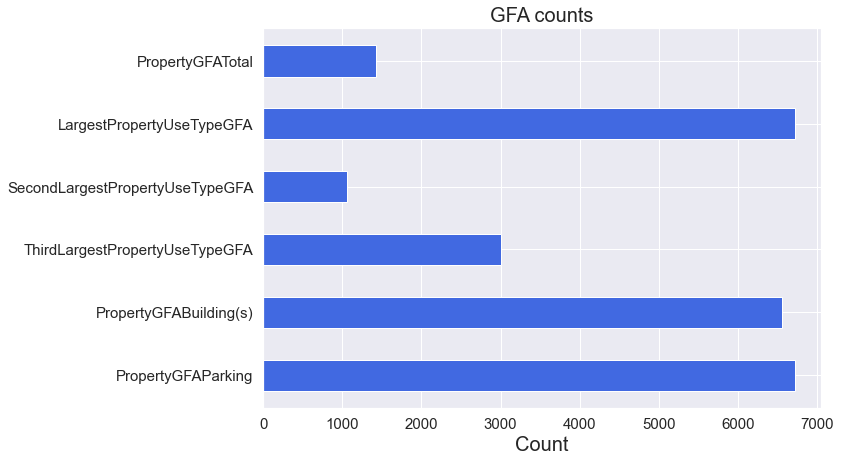

In [9]:
counts = []
for col in sqm_col:
    counts.append(((data[col]!=0)&(~data[col].isna())).sum())

sqm_col.reverse()

# Display 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,7))
width = 0.5  
ind = np.arange(len(sqm_col))    # the x locations for the groups
plt.barh(ind, counts, width, color='royalblue')
plt.xlabel('Count', fontsize=20)
plt.title('GFA counts', fontsize=20)
plt.yticks(ind, sqm_col, fontsize=15)
plt.xticks(fontsize=15)
plt.show()

sqm_col.reverse()

### Put building GFA when largest property GFA is empty 

In [10]:
data.loc[data['LargestPropertyUseTypeGFA'].isna(),'LargestPropertyUseTypeGFA'] = \
                                data[data['LargestPropertyUseTypeGFA'].isna()]['PropertyGFABuilding(s)']

### Put 1 floor when floor column is empty or equal to 0

In [11]:
data.loc[data['NumberofFloors'].isna(),'NumberofFloors'] = 1
data.loc[data['NumberofFloors']==0,'NumberofFloors'] = 1

### Fill 0 in quantity column when it's NaN

In [12]:
data.loc[data['PropertyGFAParking']< 0, 'PropertyGFAParking'] = 0

data[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = \
            data[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].fillna(0)

### Replace negative values in y columns by 0

In [13]:
# Replace negative value on y-columns by 0 (for regression on log value)
for col in y_col:
    data[data[col] < 0] = 0

### Delete row when y columns is nan 

In [14]:
for col in y_col:
    data = data[~(pd.isna(data[col]))]

## Categorical data cleaning and improvment

### Delete word's wrong end 

In [15]:
data = data.replace(r'\n$','',regex=True)

### Replace NaN case in LargestPropertyUseType by BuildingType case

In [16]:
data.loc[data['LargestPropertyUseType'].isna(),'LargestPropertyUseType'] = \
                data[data['LargestPropertyUseType'].isna()]['PrimaryPropertyType']

### Replace NaN case in Second/ThirdLargestPropertyUseType by 'Not Existing'

In [17]:
data['SecondLargestPropertyUseType'].replace([np.nan,0], "Not Existing", inplace=True)
data['ThirdLargestPropertyUseType'].replace([np.nan,0], "Not Existing", inplace=True)

In [18]:
propertyUseType_set = set(data['PrimaryPropertyType'])
propertyUseType_set = propertyUseType_set.union(set(data['LargestPropertyUseType']))
propertyUseType_set = propertyUseType_set.union(set(data['SecondLargestPropertyUseType']))
propertyUseType_set = propertyUseType_set.union(set(data['ThirdLargestPropertyUseType']))

print("Unique categories in PropertyUseType columns :", len(propertyUseType_set))

print(len(data['PrimaryPropertyType'].unique()))
print(len(data['LargestPropertyUseType'].unique()))
print(len(data['SecondLargestPropertyUseType'].unique()))
print(len(data['ThirdLargestPropertyUseType'].unique()))

unique_cat_sum = len(data['PrimaryPropertyType'].unique()) + \
                 len(data['LargestPropertyUseType'].unique()) + \
                 len(data['SecondLargestPropertyUseType'].unique()) + \
                 len(data['ThirdLargestPropertyUseType'].unique())
print("Sum of unique categories in each PropertyUseType column :", unique_cat_sum)

Unique categories in PropertyUseType columns : 78
29
65
51
46
Sum of unique categories in each PropertyUseType column : 191


### Gather some building categories

In [19]:
data['BuildingType'].replace(['Nonresidential WA','Nonresidential COS','Nonresidential'], 'NonResidential',inplace=True)
print("Unique categories in BuildingType columns :", len(data['BuildingType'].unique()))

Unique categories in BuildingType columns : 6


### Lower case in 'Neigborhood' column and gather some categories

In [20]:
data['Neighborhood'] = data['Neighborhood'].str.lower()
data['Neighborhood'].replace('delridge neighborhoods', 'delridge',inplace=True)
print("Unique categories in Neighborhood columns :", len(data['Neighborhood'].unique()))

Unique categories in Neighborhood columns : 13


### Count categories number in 'CouncilDistrictCode'

In [21]:
print("Unique categories in CouncilDistrictCode columns :", len(data['CouncilDistrictCode'].unique()))

Unique categories in CouncilDistrictCode columns : 7


## Display occupancy map

(array([5.0000e-01, 1.7250e+02, 3.4450e+02, 5.1650e+02, 6.8850e+02,
        8.6050e+02, 1.0325e+03, 1.2045e+03, 1.3765e+03, 1.5485e+03,
        1.7205e+03, 1.8925e+03, 2.0645e+03, 2.2365e+03, 2.4085e+03,
        2.5805e+03, 2.7525e+03, 2.9245e+03, 3.0965e+03, 3.2685e+03,
        3.4405e+03, 3.6125e+03, 3.7845e+03, 3.9565e+03, 4.1285e+03,
        4.3005e+03, 4.4725e+03, 4.6445e+03, 4.8165e+03, 4.9885e+03,
        5.1605e+03, 5.3325e+03, 5.5045e+03, 5.6765e+03, 5.8485e+03,
        6.0205e+03, 6.1925e+03, 6.3645e+03, 6.5365e+03]),
 [Text(0, 0.5, '1'),
  Text(0, 172.5, '280'),
  Text(0, 344.5, '484'),
  Text(0, 516.5, '701'),
  Text(0, 688.5, '19579'),
  Text(0, 860.5, '20009'),
  Text(0, 1032.5, '20529'),
  Text(0, 1204.5, '21226'),
  Text(0, 1376.5, '21649'),
  Text(0, 1548.5, '22332'),
  Text(0, 1720.5, '23173'),
  Text(0, 1892.5, '23679'),
  Text(0, 2064.5, '24249'),
  Text(0, 2236.5, '24850'),
  Text(0, 2408.5, '25491'),
  Text(0, 2580.5, '26095'),
  Text(0, 2752.5, '26743'),
  Text(0

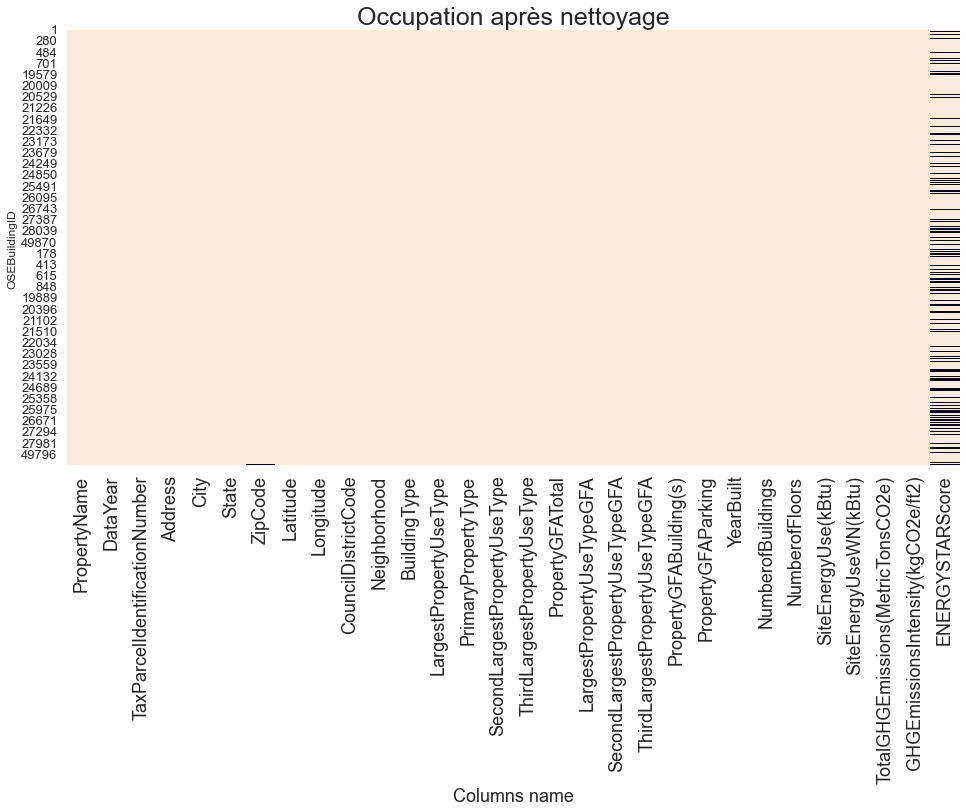

In [22]:
import seaborn as sns 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16,8))

# Plot heatmap of boolean cleaned dataframe
data_bin = ~data[id_col+des_col+sqm_col+dis_col+y_col+es_col].isnull()
sns.heatmap(data_bin, cbar=False, ax=axes)

axes.set_title("Occupation après nettoyage", fontdict = {
                             'fontsize': 25,
                            })
plt.xticks(size=18, rotation=90)
plt.xlabel('Columns name', fontsize=18)
plt.yticks(size=13)

In [23]:
selected_data = data[id_col+des_col+sqm_col+dis_col+y_col+es_col]

selected_data[selected_data["DataYear"]==2015].to_csv('2015-building-energy-benchmarking_selected.csv', sep=',')
selected_data[selected_data["DataYear"]==2016].to_csv('2016-building-energy-benchmarking_selected.csv', sep=',')

# Exploration

In [24]:
# Define function to delete outlier in some column
def deleteOutlier(col, quantile):
    col_numeric = pd.to_numeric(col.to_numpy(), errors='coerce')
    # Create boolean list for outlier : x < Q1 - 1.5 * IQR | x > Q3 + 1.5 * IQR
    Q1 = col[~np.isnan(col_numeric)].quantile(quantile)
    Q3 = col[~np.isnan(col_numeric)].quantile(1-quantile)
    IQR = Q3 - Q1
    out_IQR_col = (col_numeric < (Q1 - 1.5 * IQR)) | (col_numeric > (Q3 + 1.5 * IQR))
    new_col = col
    new_col[out_IQR_col] = np.nan
    return new_col

# Apply function to delete outlier in quantity columns
data_y_filter = data[y_col].copy()
data_y_filter = data_y_filter.apply(lambda col : deleteOutlier(col, 0.25))

# Print columns list with detected outliers in each column
print(data[y_col].count() - data_y_filter.count())

print('Before outlier deletion :', len(data))
data_y_filter = data[~data_y_filter.isna().any(axis=1)]
print('After outlier deletion :', len(data_y_filter))

SiteEnergyUse(kBtu)                  782
SiteEnergyUseWN(kBtu)                757
TotalGHGEmissions(MetricTonsCO2e)    732
GHGEmissionsIntensity(kgCO2e/ft2)    535
dtype: int64
Before outlier deletion : 6694
After outlier deletion : 5483


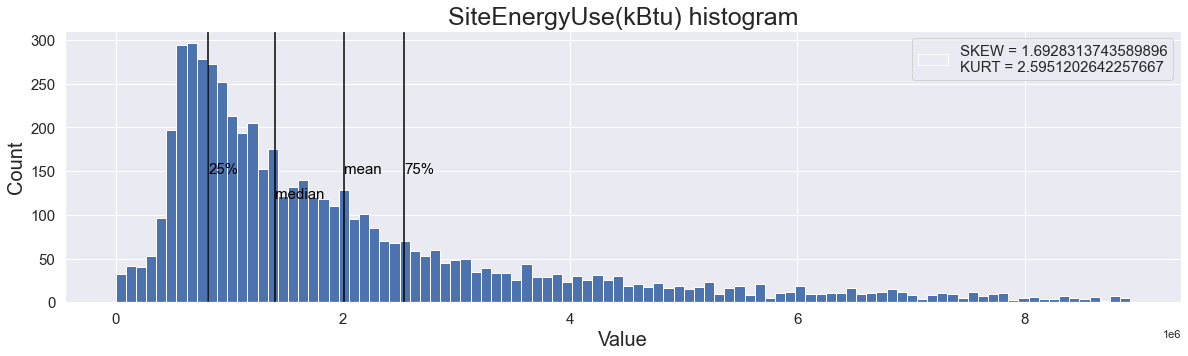

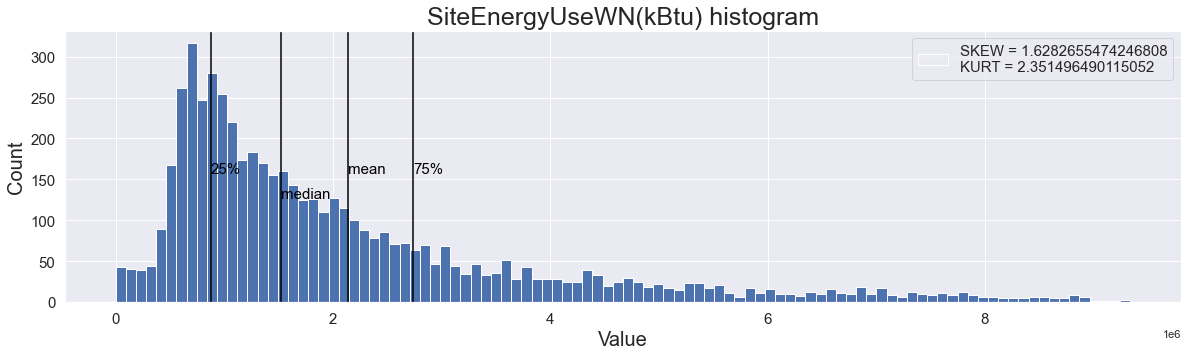

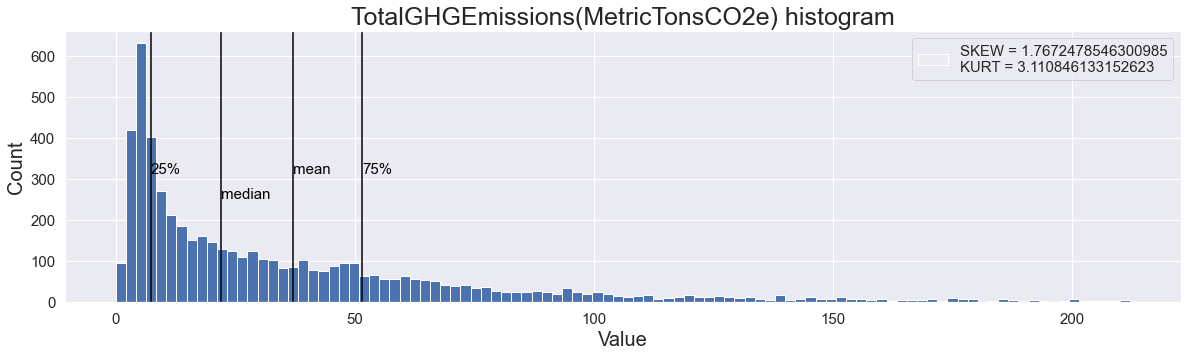

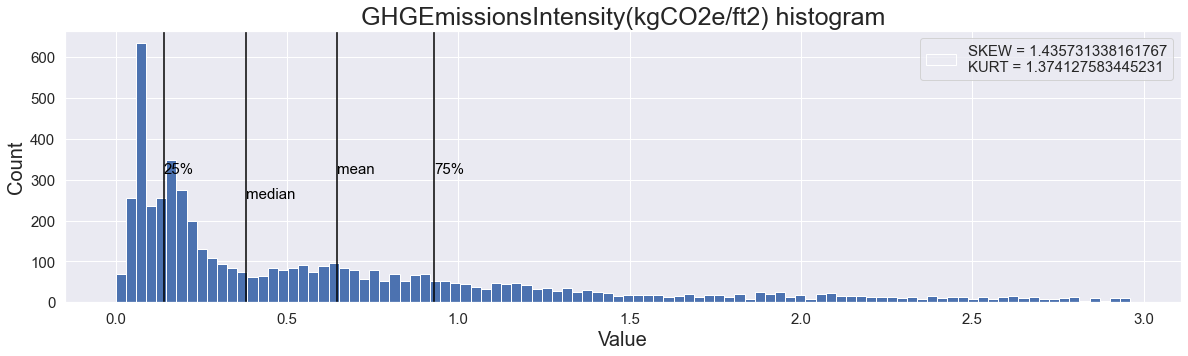

,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),TotalGHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2)
count,5.483000e+03,5.483000e+03,5483.000000,5483.000000
mean,2.009933e+06,2.137647e+06,37.122650,0.647518
std,1.726325e+06,1.799082e+06,40.290412,0.684982
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,8.153638e+05,8.775895e+05,7.360000,0.140000
50%,1.403095e+06,1.520963e+06,22.010000,0.380000
75%,2.539859e+06,2.738024e+06,51.530000,0.930000
max,8.926736e+06,9.336260e+06,212.060000,2.960000
SKEW,1.692831e+00,1.628266e+00,1.767248,1.435731
KURT,2.595120e+00,2.351496e+00,3.110846,1.374128


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.patches as mpatches

tab = data_y_filter[y_col].describe(percentiles=[.25, .75])
tab.loc["SKEW"] = data_y_filter[y_col].skew()
tab.loc["KURT"] = data_y_filter[y_col].kurtosis()


for col in y_col:
    fig, ax = plt.subplots(figsize=(20,5))
    values = data_y_filter[col][~np.isnan(data_y_filter[col])]
    
    y, x, _ = ax.hist(values, bins = 100)
    
    ax.axvline(tab.loc["mean",col], color='black')
    ax.axvline(tab.loc["25%",col], color='black')
    ax.axvline(tab.loc["50%",col], color='black')
    ax.axvline(tab.loc["75%",col], color='black')
    
    ax.text(tab.loc["mean",col], 0.5 * y.max(), 'mean',color='black',fontsize=15)
    ax.text(tab.loc["25%",col], 0.5 * y.max(), '25%',color='black',fontsize=15)
    ax.text(tab.loc["50%",col], 0.4 * y.max(), 'median',color='black',fontsize=15)
    ax.text(tab.loc["75%",col], 0.5 * y.max(), '75%',color='black',fontsize=15)
    
    label = 'SKEW = '+ str(tab.loc["SKEW", col]) + '\n' + 'KURT = '+ str(tab.loc["KURT", col])

    red_patch = mpatches.Patch(label=label, fill=False)
    ax.legend(handles=[red_patch], fontsize=15) 
    
    plt.xlabel('Value', fontsize=20)
    plt.ylabel('Count', fontsize=20)
    plt.title(col+' histogram', fontsize=25)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.show()
    
tab

In [26]:
tab = data[dis_col+sqm_col+es_col].describe(percentiles=[.25, .75])

tab.loc["IQR"] = data[dis_col+sqm_col].apply(
    lambda col: col.quantile(0.75) - col.quantile(0.25), axis = 0)
tab.loc["VAR"] = data[dis_col+sqm_col].var()
tab.loc["SKEW"] = data[dis_col+sqm_col].skew()
tab.loc["KURT"] = data[dis_col+sqm_col].kurtosis()

tab

,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,PropertyGFABuilding(s),PropertyGFAParking,ENERGYSTARScore
count,6694.000000,6694.000000,6694.000000,6.694000e+03,6.694000e+03,6.694000e+03,6.694000e+03,6.694000e+03,6.694000e+03,5090.000000
mean,1968.107708,1.071557,4.699283,9.297073e+04,7.725809e+04,1.357636e+04,1.944943e+03,8.343629e+04,9.534441e+03,67.888802
std,33.038449,1.595167,5.479566,1.877881e+05,1.671332e+05,3.974751e+04,1.172078e+04,1.736106e+05,3.390676e+04,27.010296
min,1900.000000,0.000000,1.000000,1.128500e+04,5.656000e+03,0.000000e+00,0.000000e+00,-5.055000e+04,0.000000e+00,1.000000
25%,1948.000000,1.000000,2.000000,2.847050e+04,2.509175e+04,0.000000e+00,0.000000e+00,2.727225e+04,0.000000e+00,52.000000
50%,1974.000000,1.000000,4.000000,4.409800e+04,3.960000e+04,0.000000e+00,0.000000e+00,4.221400e+04,0.000000e+00,75.000000
75%,1997.000000,1.000000,5.000000,8.955000e+04,7.483775e+04,1.021025e+04,0.000000e+00,8.140050e+04,0.000000e+00,90.000000
max,2015.000000,111.000000,99.000000,9.320156e+06,9.320156e+06,6.867500e+05,4.597480e+05,9.320156e+06,5.126080e+05,100.000000
IQR,49.000000,0.000000,3.000000,6.107950e+04,4.974600e+04,1.021025e+04,0.000000e+00,5.412825e+04,0.000000e+00,NaN
VAR,1091.539122,2.544558,30.025647,3.526438e+10,2.793352e+10,1.579865e+09,1.373766e+08,3.014064e+10,1.149669e+09,NaN


In [27]:
# Apply function to delete outlier in quantity columns
data_filter = data[sqm_col].copy()

data_filter = data_filter.apply(lambda col : deleteOutlier(col, 0.1))

# Print columns list with detected outliers in each column
print(data[sqm_col].count() - data_filter.count())

print('Before outlier deletion :', len(data))
data_to_display = data[~data_filter.isna().any(axis=1)]
print('After outlier deletion :', len(data_to_display))

PropertyGFATotal                   159
LargestPropertyUseTypeGFA          166
SecondLargestPropertyUseTypeGFA    268
ThirdLargestPropertyUseTypeGFA     286
PropertyGFABuilding(s)             173
PropertyGFAParking                 333
dtype: int64
Before outlier deletion : 6694
After outlier deletion : 6036


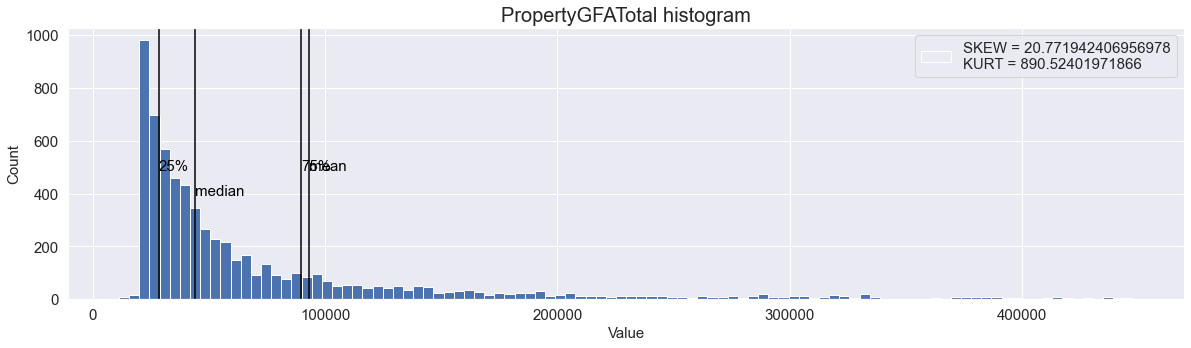

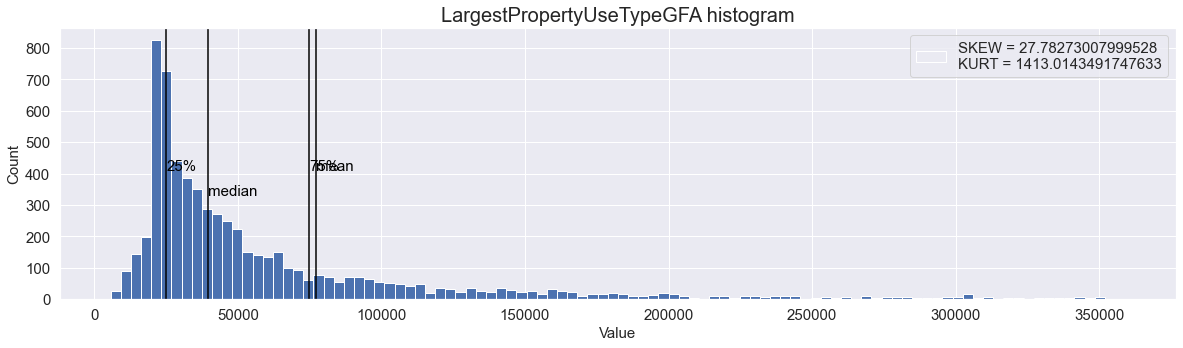

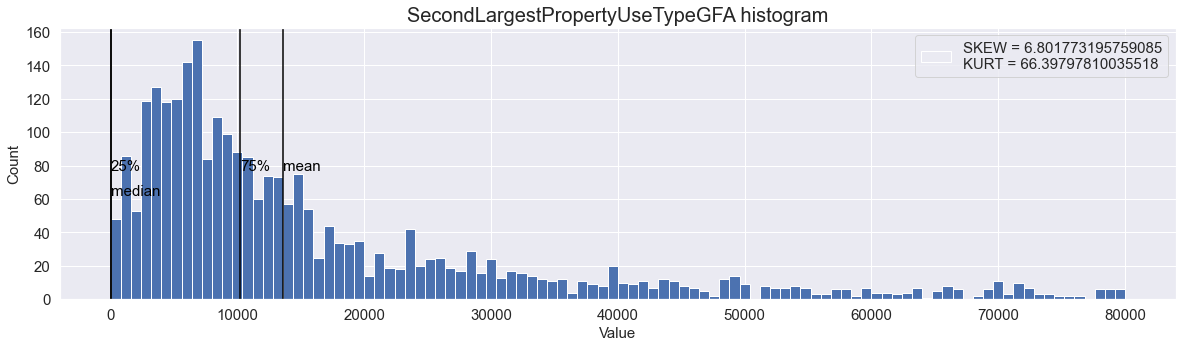

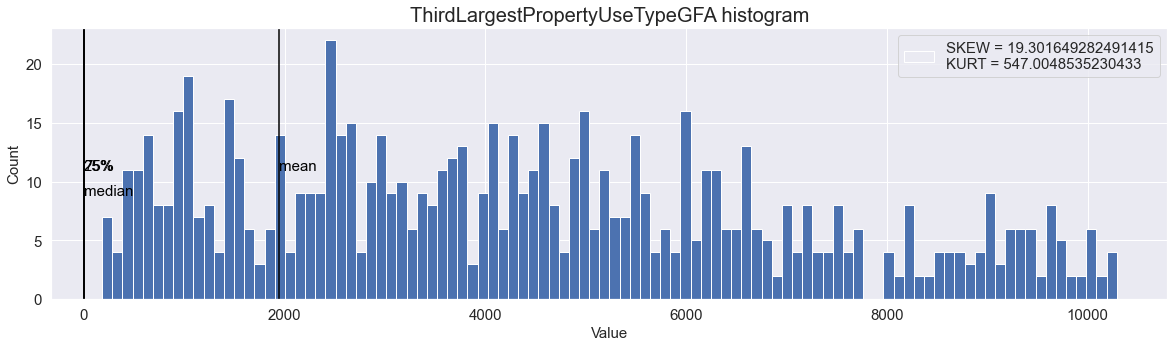

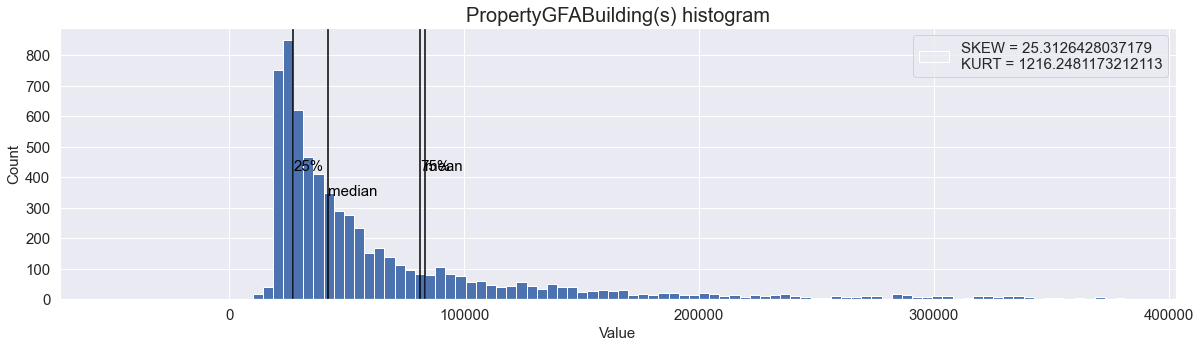

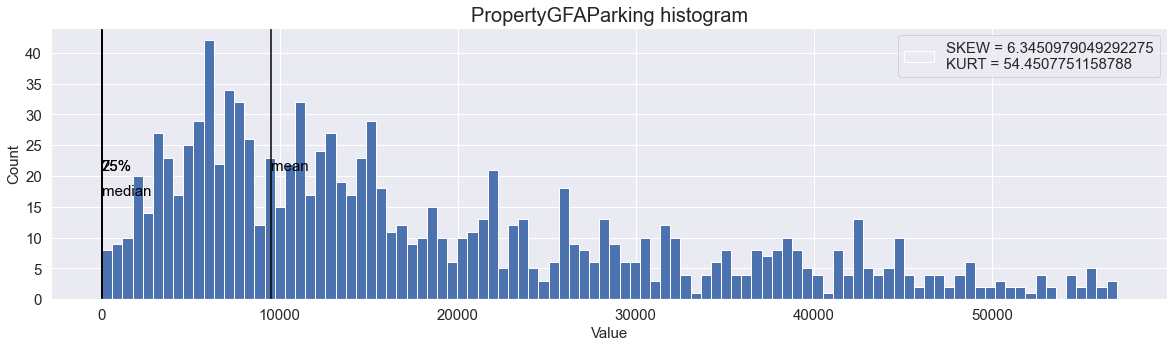

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
sns.set(style="darkgrid")
for col in sqm_col:
    fig, ax = plt.subplots(figsize=(20,5))
    values = data_filter[col][~(data_filter[col]==0)]
    #sns.histplot(values,kde=True, ax=ax)
    
    y, x, _ = ax.hist(values, bins = 100)
    
    ax.axvline(tab.loc["mean",col], color='black')
    ax.axvline(tab.loc["25%",col], color='black')
    ax.axvline(tab.loc["50%",col], color='black')
    ax.axvline(tab.loc["75%",col], color='black')
    
    ax.text(tab.loc["mean",col], 0.5 * y.max(), 'mean',color='black',fontsize=15)
    ax.text(tab.loc["25%",col], 0.5 * y.max(), '25%',color='black',fontsize=15)
    ax.text(tab.loc["50%",col], 0.4 * y.max(), 'median',color='black',fontsize=15)
    ax.text(tab.loc["75%",col], 0.5 * y.max(), '75%',color='black',fontsize=15)
    
    label = 'SKEW = '+ str(tab.loc["SKEW", col]) + '\n' + 'KURT = '+ str(tab.loc["KURT", col])
    
    red_patch = mpatches.Patch(label=label, fill=False)
    ax.legend(handles=[red_patch], fontsize=15)   

    plt.xlabel('Value', fontsize=15)
    plt.ylabel('Count', fontsize=15)
    plt.title(col+' histogram', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

plt.show()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

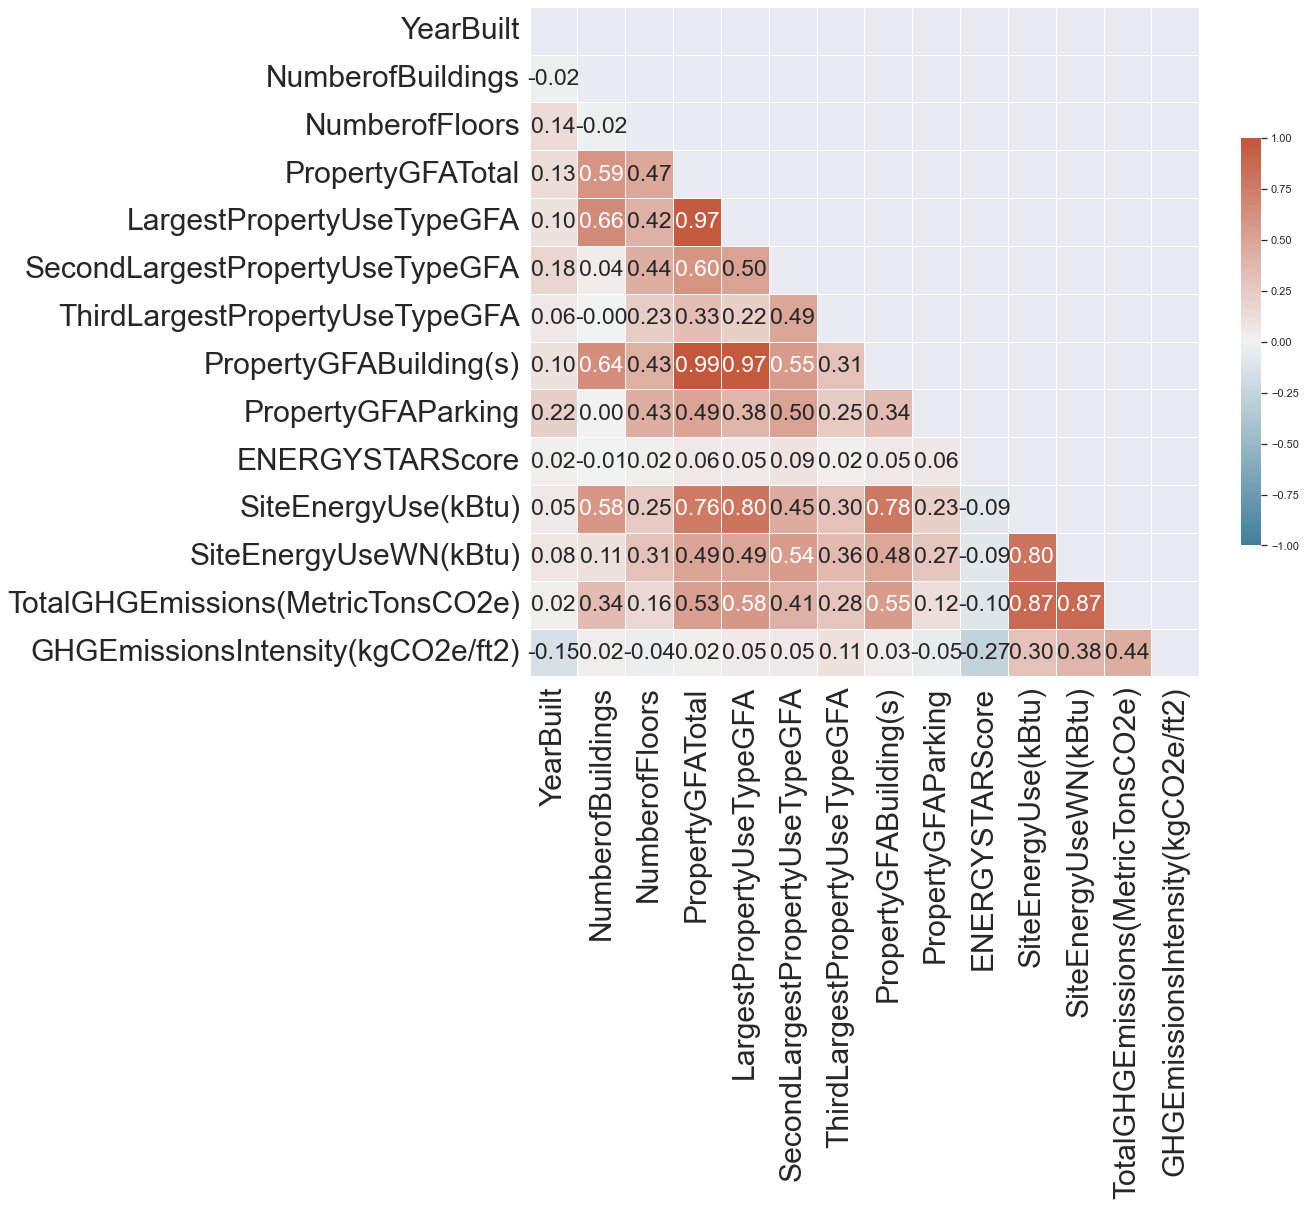

In [36]:
import seaborn as sns
sns.set_theme(style="darkgrid")

sqm_col_display = ['PropertyGFATotal', 
           'LargestPropertyGFA', 'SecondLargestTypeGFA', 
           'ThirdLargestTypeGFA', 'PropertyGFABuilding(s)', 'PropertyGFAParking']

y_col_display = ['SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 
         'TotalGHGEmissions', 'GHGEmissionsIntensity']

# Compute the correlation matrix
corr = data[dis_col+sqm_col+es_col+y_col].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, 
            annot=True, fmt='.2f', annot_kws={"size": 23})

plt.setp(plt.gca().get_xticklabels(), rotation=90, ha='center', fontsize=30)
plt.setp(plt.gca().get_yticklabels(), fontsize=30)

#ind = np.arange(len(dis_col+sqm_col+es_col+y_col))
#plt.xticks(ind+0.5, dis_col+sqm_col_display+es_col+y_col_display, fontsize=25)
#plt.yticks(ind+0.5, dis_col+sqm_col_display+es_col+y_col_display, fontsize=25,rotation=0)

In [37]:
mean_df = data[["BuildingType", "SiteEnergyUseWN(kBtu)"]].groupby("BuildingType")\
                                                .mean().sort_values("SiteEnergyUseWN(kBtu)")
               
print(mean_df)

                      SiteEnergyUseWN(kBtu)
BuildingType                               
Multifamily LR (1-4)           1.501993e+06
Multifamily MR (5-9)           3.016066e+06
SPS-District K-12              3.827699e+06
NonResidential                 7.735155e+06
Multifamily HR (10+)           1.009737e+07
Campus                         4.268196e+07


/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/p0/r9j8yslx4_18sgx9jxyw5fmm0000gn/T/ipykernel_1351/2990129067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tp['log_data'] = np.log10(df_tp["SiteEnergyUseWN(kBtu)"])


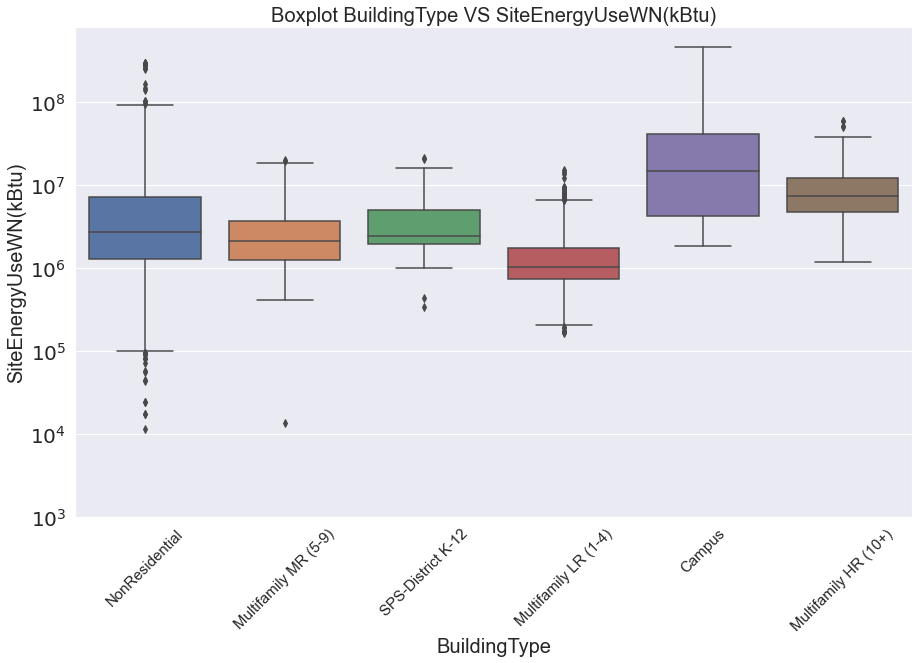

In [38]:
from matplotlib import ticker as mticker

df_tp = data[["BuildingType", "SiteEnergyUseWN(kBtu)"]]
df_tp['log_data'] = np.log10(df_tp["SiteEnergyUseWN(kBtu)"])
df_tp = df_tp[~(np.isnan(df_tp['log_data'])|np.isinf(df_tp['log_data']))]

sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 9))

ax = sns.boxplot(x="BuildingType", y='log_data', data=df_tp)

ax.yaxis.set_ticks([np.log10(10**p) for p in range(int(df_tp["log_data"].min())-1,int(df_tp["log_data"].max())+1)], 
                  minor=True)

ax.yaxis.set_major_formatter(mticker.StrMethodFormatter("$10^{{{x:.0f}}}$"))

plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=20,rotation=0)

plt.xlabel("BuildingType", fontsize=20)
plt.ylabel("SiteEnergyUseWN(kBtu)", fontsize=20)

plt.title(('Boxplot {} VS {}').format("BuildingType", "SiteEnergyUseWN(kBtu)"), fontsize=20)
plt.show()      

['downtown' 'southeast' 'northeast' 'east' 'central' 'north'
 'magnolia / queen anne' 'lake union' 'greater duwamish' 'ballard'
 'northwest' 'southwest' 'delridge']


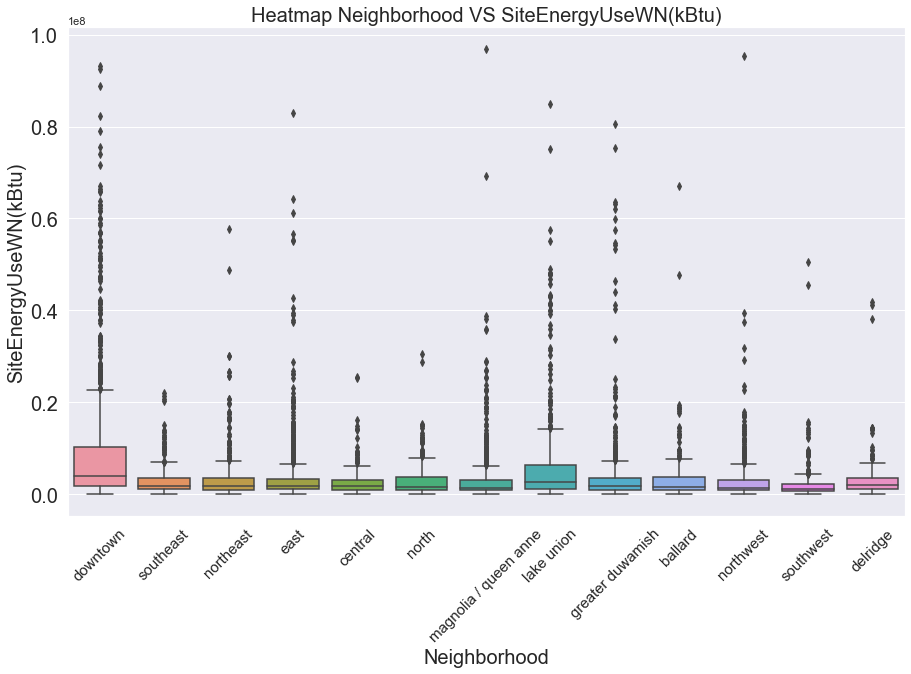

In [39]:
from matplotlib import ticker as mticker

# A FAIRE BOXPLOT
print(data['Neighborhood'].unique())

df_tp = data[["Neighborhood", "SiteEnergyUseWN(kBtu)"]]

df_tp = df_tp[df_tp["SiteEnergyUseWN(kBtu)"] < 1e8]

sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 9))

ax = sns.boxplot(x="Neighborhood", y='SiteEnergyUseWN(kBtu)', data=df_tp)

plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=20,rotation=0)

plt.xlabel("Neighborhood", fontsize=20)
plt.ylabel("SiteEnergyUseWN(kBtu)", fontsize=20)

plt.title(('Heatmap {} VS {}').format("Neighborhood", "SiteEnergyUseWN(kBtu)"), fontsize=20)
plt.show()  

[7 3 2 4 5 6 1]


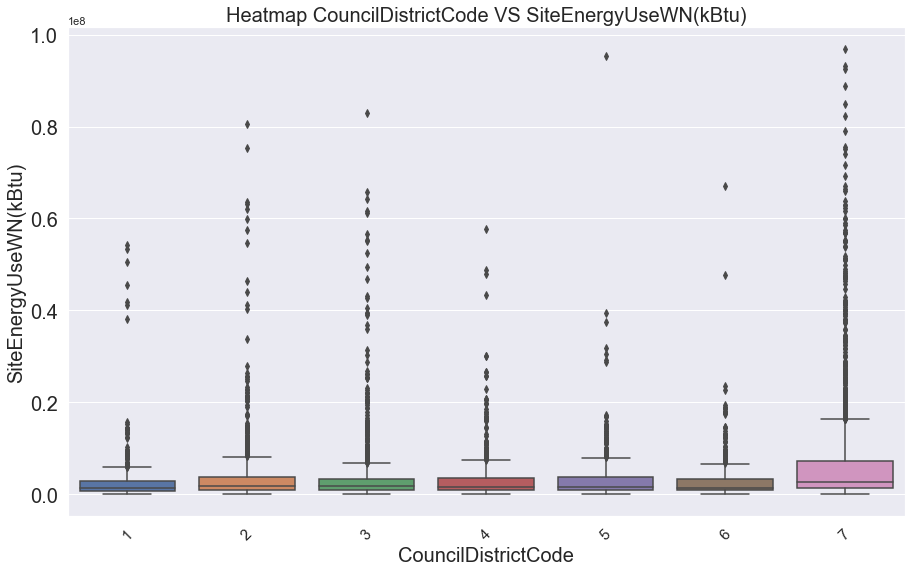

In [40]:
from matplotlib import ticker as mticker

# A FAIRE BOXPLOT
print(data['CouncilDistrictCode'].unique())

df_tp = data[["CouncilDistrictCode", "SiteEnergyUseWN(kBtu)"]]

df_tp = df_tp[df_tp["SiteEnergyUseWN(kBtu)"] < 1e8]

sns.set_theme(style="darkgrid")
f, ax = plt.subplots(figsize=(15, 9))

ax = sns.boxplot(x="CouncilDistrictCode", y='SiteEnergyUseWN(kBtu)', data=df_tp)

plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=20,rotation=0)

plt.xlabel("CouncilDistrictCode", fontsize=20)
plt.ylabel("SiteEnergyUseWN(kBtu)", fontsize=20)

plt.title(('Heatmap {} VS {}').format("CouncilDistrictCode", "SiteEnergyUseWN(kBtu)"), fontsize=20)
plt.show()  